## Class Activation Maps

## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

See [ResNet-34](https://www.kaggle.com/pytorch/resnet34) for Deep Residual Learning for Image Recognition

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)   # True means to load the pretrained

In [4]:
m

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

We need to predict Dogs vs Cats, (and not ImageNet classes). 
so we need to remove the last layer, because it produces 1000 features (as required for ImageNet). 
When we use ConvLearner_from_pretrained from fastai it actually deletes the (fc)layer, 
and also deletes the previous (avgpool) layer. 

Fastai replaces that by using the AdapativeAveragePooling, and AdaptiveMaxPooling and concat them together.

Now we do a simple version, delete the last two layers and add a convolution which has 2 outputs, then average pooling, then softmax.  
This will result in only 2 numbers as output.

children(m)[:-2] - leave out the last two layers

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

Freeze every single layer, except for layer (-4), which is the `nn.Conv2d(512, 2, 3, padding=1), `

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

Now train only the (-4) layer.

In [11]:
learn.fit(0.01, 1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.132085   0.061699   0.9905    



[array([ 0.0617]), 0.99050000000000005]

In [12]:
learn.fit(0.01, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.063108   0.066874   0.9895    



[array([ 0.06687]), 0.98950000000000005]

## CAM - Class Activation Maps
We going to use a technique CAM, and ask the model ‘which parts of the picture are useful?’.

How does this work? It produces a matrix, simply equal to the value of feature matrix times py vector. py is the predictions.

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [14]:
x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]   # single channel?

vx = Variable(x.cuda(), requires_grad=True)

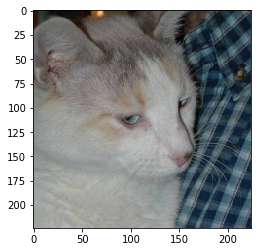

In [15]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [16]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([ 1.,  0.], dtype=float32)

In [17]:
feat = np.maximum(0, sf.features[0])
feat.shape   # feat is 2 filters of 7 by 7

(2, 7, 7)

In [18]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[ 0.0557 ,  0.18646,  0.28774,  0.35264,  0.34072,  0.24718,  0.08418],
       [ 0.1558 ,  0.37772,  0.56348,  0.69262,  0.67633,  0.49091,  0.19004],
       [ 0.20251,  0.51857,  0.79048,  0.91274,  0.85992,  0.59478,  0.23894],
       [ 0.18627,  0.5179 ,  0.84294,  1.     ,  0.95425,  0.66121,  0.26612],
       [ 0.15871,  0.48061,  0.83378,  0.99148,  0.91365,  0.61471,  0.23282],
       [ 0.10539,  0.36687,  0.67216,  0.81677,  0.75183,  0.49106,  0.16975],
       [ 0.     ,  0.14023,  0.31014,  0.36896,  0.32661,  0.18901,  0.02561]], dtype=float32)

/home/german/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


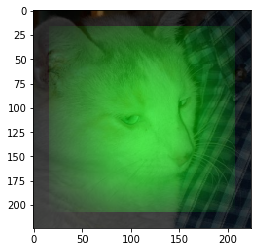

In [19]:
from skimage.transform import resize
plt.imshow(dx)
#plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');
plt.imshow(resize(f2, dx.shape), alpha=0.6, cmap='hot');

## Model

In [20]:
learn.unfreeze()
learn.bn_freeze(True)

In [21]:
#lr=np.array([1e-6,1e-4,1e-2])
lr=[1e-6,1e-4,1e-2]   # fastai used to support this as 3 layer "groups", but now it does not, so one needs to know the numb of layers
type(lr)

list

In [22]:
lr = 1e-4

In [23]:
learn.fit(lr, 2)   # cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.066698   0.073379   0.9855    
    1      0.021878   0.044261   0.989                        



[array([ 0.04426]), 0.98899999999999999]

In [24]:
#interogativ This is because you are comparing an autograd variable to a tensor. Here's how I got around this:
def accuracy1(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    #print ('preds: {}, {}'.format(preds.shape,type(preds)))
    #print ('targs: {}, {}'.format(targs.shape,type(targs)))
    return (preds==targs.data).float().mean()

In [25]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.99050000000000005

In [26]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.015868   0.038025   0.9885    
    1      0.013841   0.036751   0.99                         



[array([ 0.03675]), 0.98999999999999999]

In [27]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.99150000000000005